# Quantum Federated Learning with Genomic Data

This Jupyter Notebook demonstrates the use of Quantum Federated Learning (QFL) with genomic data. Quantum computing has the potential to revolutionize machine learning by offering unique computational advantages. In this notebook, we'll use the Qiskit and Genomic Benchmarks libraries to explore the concept of federated learning, which is a decentralized approach to machine learning.

## Required Dependencies

Before proceeding with the code execution, it is essential to ensure that you have the necessary libraries installed. The following commands will help you install these libraries:

The line `%%capture` prevents any pip logs from being displayed here.




In [ ]:
%%capture
!pip install genomic-benchmarks
!pip install qiskit qiskit_machine_learning qiskit_algorithms
!pip install qiskit-aer

## Data Collection

In this section, our main objective is to gather the necessary data for our Quantum Federated Learning experiment. We will use the `genomic_benchmarks` library to work with a dataset designed for classifying DNA sequences as either human or worm.

To start collecting our data, we'll import the required dataset using the `DemoHumanOrWorm` class from the `genomic_benchmarks.dataset_getters.pytorch_datasets` module. This dataset comes with both a training set and a test set. However, during testing, we noticed some issues with the `test_set` variable in fetching the correct data. For our current purpose, we'll focus solely on the `train_set` variable, which holds a substantial 75,000 samples.

> If your specific use case requires it, you can include the test set as well by uncommenting the relevant line of code.




In [1]:
from genomic_benchmarks.dataset_getters.pytorch_datasets import DemoHumanOrWorm

test_set = DemoHumanOrWorm(split='test', version=0)
train_set = DemoHumanOrWorm(split='train', version=0)

data_set = train_set
# data_set = train_set + test_set
len(data_set)

d:\Software\Anaconda2022.10\envs\qfl\lib\site-packages\genomic_benchmarks\utils\datasets.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


75000

## Testing Set Size

Before we move further, let's check the size of the testing and training set variables. We have previously mentioned that there were some issues with the `test_set` variable during data collection. We'll assess its current state.

In [2]:
print(f"Nuber of samples in the test set: {len(test_set)}")
print(f"Nuber of samples in the train set: {len(train_set)}")

Nuber of samples in the test set: 25000
Nuber of samples in the train set: 75000


## Genomics Data

Now, let's take a closer look at what the genomic data looks like. The data consists of DNA sequences, each represented as a string with a length of 200 characters, and an associated label, which can be either 0 or 1. In this context, 0 typically represents human DNA, while 1 corresponds to worm DNA.

For our specific use case, we need to reduce the dimensionality of this data. One approach is to encode the DNA sequence characters as follows:
- 'A' as 1
- 'T' as 2
- 'C' as 3
- 'G' as 4
- 'N' as 5

Since we know that DNA sequences contain only these characters. However, working with 200 features for each sequence might be too complex. In the next step, we'll work on reducing the dimensionality of this data from 200 features down to a single digit, such as 5 or 4.


In [3]:
print("One sample from the data_set variable: ")
data_set[0]

One sample from the data_set variable: 


('TCAGCCTCCCAAGTAGCTGGGACTACATGCCCTTGCCTCTGCTTTGTTTTCCATTATTTTCTCACATGTCAGGCTTCATTATATGTTTCACAGTCTTTATTATTATTTACCTTCCTCAGCTAGAATGTGAGTCCACAAGGATAGGTCTGAACTCTTTTACTCACAGCATTTCTGACCCCCAAATATGTGTCTTTTGTCCT',
 0)

## Creating a Dictionary of DNA Sequence Representations

In the following code snippet, we create a dictionary named `word_combinations`. This dictionary is designed to hold numerical representations of DNA sequences. Our goal is to convert the DNA sequences into a more manageable format.

To achieve this, we define a variable called `word_size`, which specifies the length of each word we want to consider in the DNA sequence. In this particular case, `word_size` is set to 40, but you can adjust it based on your specific requirements.

The code iterates through each DNA sequence in the `data_set` and extracts overlapping subsequences of length `word_size`. These subsequences are represented as "words." For each unique word encountered in the DNA sequences, we assign a numerical representation.

The resulting `word_combinations` dictionary stores these numerical representations, allowing us to work with a simplified version of the DNA data.


In [4]:
from collections import defaultdict
import numpy as np

word_size = 40
word_combinations = defaultdict(int)
iteration = 1
for text, _ in data_set:
    for i in range(len(text)):
        word = text[i:i+word_size]
        if word_combinations.get(word) is None:
          word_combinations[word] = iteration
          iteration += 1

Let us look at how the word combination dict actually looks like

## Examining Word Combinations and Data Sample

Let's explore the contents of our `word_combinations` variable and relate it to the first sample from our data.

We can observe that the sample consists of a DNA sequence of 200 characters, with the label 0. The word_combinations dictionary assigns numerical labels to DNA sequence subsequences. For example, the first 40 characters of the sample are labeled as 1, the next 40 characters are labeled as 2, and so on.

The first sample in the `data_set` variable is as follows:
```python
('GTGTCATTCAGCCAAGAGGCAAAAATAAACCACAGTTTTTTTTCCATTCTTTTAAGCCAATAAGCAGTACATGGTATGATTATTGGGGTGCTGATTATGGGACCTACAATTACAACCCTTACATTGGAGGTCTGGGAATTCCTGTAGCAAAGCCACCAGCAAACACGGAGAAGAACGGATCACAGACAGTTAGCGTTTCA', 0)



In [23]:
print("First sample int the data_set variable: ")
print(data_set[0])

print("\nFirst 5 samples in the word_combinations dict.")
for key, value in list(word_combinations.items())[:10]:
    print(key, value)

First sample int the data_set variable: 
('TCAGCCTCCCAAGTAGCTGGGACTACATGCCCTTGCCTCTGCTTTGTTTTCCATTATTTTCTCACATGTCAGGCTTCATTATATGTTTCACAGTCTTTATTATTATTTACCTTCCTCAGCTAGAATGTGAGTCCACAAGGATAGGTCTGAACTCTTTTACTCACAGCATTTCTGACCCCCAAATATGTGTCTTTTGTCCT', 0)

First 5 samples in the word_combinations dict.
TCAGCCTCCCAAGTAGCTGGGACTACATGCCCTTGCCTCT 1
CAGCCTCCCAAGTAGCTGGGACTACATGCCCTTGCCTCTG 2
AGCCTCCCAAGTAGCTGGGACTACATGCCCTTGCCTCTGC 3
GCCTCCCAAGTAGCTGGGACTACATGCCCTTGCCTCTGCT 4
CCTCCCAAGTAGCTGGGACTACATGCCCTTGCCTCTGCTT 5
CTCCCAAGTAGCTGGGACTACATGCCCTTGCCTCTGCTTT 6
TCCCAAGTAGCTGGGACTACATGCCCTTGCCTCTGCTTTG 7
CCCAAGTAGCTGGGACTACATGCCCTTGCCTCTGCTTTGT 8
CCAAGTAGCTGGGACTACATGCCCTTGCCTCTGCTTTGTT 9
CAAGTAGCTGGGACTACATGCCCTTGCCTCTGCTTTGTTT 10


## Encoding DNA Sequences

In the following code segment, we encode the 200-character DNA sequences into smaller samples, each comprising 200 divided by the `word_size` segments. This encoding allows us to represent the DNA sequences in a numerical format by assigning a numerical value from the `word_combinations` dictionary to each segment.

The specific steps in the code include:
1. Stripping any leading or trailing whitespace from the DNA sequence.
2. Dividing the DNA sequence into `word_size`-letter word segments using a sliding window approach.
3. Converting these word segments into their corresponding numerical values as per the `word_combinations` dictionary.
4. Organizing the data into a structured format that includes the numerical sequence and its associated label.

The resulting `np_data_set` holds these encoded data points.

In [24]:
import numpy as np
# Preprocess the training set
np_data_set = []
for i in range(len(data_set)):
    sequence, label = data_set[i]
    sequence = sequence.strip()  # Remove any leading/trailing whitespace
    words = [sequence[i:i + word_size] for i in range(0, len(sequence), word_size)]  # Split the sequence into 4-letter words
    int_sequence = np.array([word_combinations[word] for word in words])
    data_point = {'sequence': int_sequence, 'label': label}
    np_data_set.append(data_point)


print("First 5 samples of encoded data:")
np_data_set[:5]

First 5 samples of encoded data:


[{'sequence': array([  1,  41,  81, 121, 161]), 'label': 0},
 {'sequence': array([201, 201, 201, 201, 201]), 'label': 0},
 {'sequence': array([241, 281, 321, 361, 401]), 'label': 0},
 {'sequence': array([441, 481, 521, 561, 601]), 'label': 0},
 {'sequence': array([641, 681, 721, 761, 801]), 'label': 0}]

## Shuffling Data for Balanced Distribution

In the code segment above, we observe the first 5 samples of the `np_data_set` variable. It's apparent that all of these initial samples have a label of 0. This observation is due to the common dataset structure, where the data is organized such that the first batch of samples belongs to one class (in this case, class 0), followed by another class (class 1), and so on.

However, in the subsequent steps of this code, we'll divide the data into portions for each of our clients, and it's crucial to ensure that each client receives a balanced mix of data from both classes (0 and 1). Therefore, we need to shuffle the `np_data_set` variable.

Shuffling the dataset randomizes the order of samples, guaranteeing that no single client will receive data only from one class. This is essential for a more representative and fair distribution of data among clients.


In [26]:
np.random.shuffle(np_data_set)
print("First 5 samples of encoded shuffled data:")
np_data_set[:5]

First 5 samples of encoded shuffled data:


[{'sequence': array([1895519, 1895559, 1895599, 1895639, 1895679]),
  'label': 0},
 {'sequence': array([3715400, 3715440, 3715480, 3715520, 3715560]),
  'label': 0},
 {'sequence': array([2646605, 2646645, 2646685, 2646725, 2646760]),
  'label': 0},
 {'sequence': array([4425422, 4425462, 4425502, 4425542, 4425582]),
  'label': 0},
 {'sequence': array([798326, 798366, 798406, 798446, 798486]), 'label': 0}]

## Scaling the Data with Min-Max Scaling

In the code provided, we apply Min-Max scaling to the dataset to normalize the numerical values. This process is valuable for ensuring that the features of the dataset are within a consistent range, typically between 0 and 1.

Here's how the code accomplishes this:
1. We collect the sequences from the `np_data_set` variable and stack them into an array.
2. We create a `MinMaxScaler` object, which will be used to perform the scaling.
3. The scaler is then applied to the sequences using `scaler.fit_transform()`.
4. The scaled sequences are replaced in each data point within the `np_data_set` variable.

As a result, the sequences' values are transformed to a standardized scale, making it easier to work with the data and ensuring that each feature has the same weight in subsequent analyses.

The output displays the first 5 samples of the scaled, encoded, and shuffled data, highlighting how the values are now in the [0, 1] range after the scaling process.


In [27]:
from sklearn.preprocessing import MinMaxScaler

sequences = np.array([item['sequence'] for item in np_data_set])
sequences = np.vstack(sequences)

scaler = MinMaxScaler()

sequences_scaled = scaler.fit_transform(sequences)

for i, item in enumerate(np_data_set):
    item['sequence'] = sequences_scaled[i]

print("First 5 samples of scaled encoded shuffled data:")
np_data_set[:5]

First 5 samples of scaled encoded shuffled data:


[{'sequence': array([0.13737511, 0.13737511, 0.13737388, 0.13737388, 0.13737388]),
  'label': 0},
 {'sequence': array([0.26926853, 0.26926853, 0.26926611, 0.26926611, 0.26926611]),
  'label': 0},
 {'sequence': array([0.19180906, 0.19180906, 0.19180733, 0.19180733, 0.19180697]),
  'label': 0},
 {'sequence': array([0.32072642, 0.32072642, 0.32072354, 0.32072354, 0.32072354]),
  'label': 0},
 {'sequence': array([0.05785753, 0.05785753, 0.05785701, 0.05785701, 0.05785701]),
  'label': 0}]

## Splitting the Dataset and Preparing Test Data

In the previous section, we divided the `np_data_set` variable into two subsets, with 70,000 samples earmarked for training and 5,000 samples reserved for testing. This division is crucial for the development and evaluation of our Quantum Federated Learning model, ensuring that we have separate datasets for these purposes.

Following the split, we proceed to prepare the test data for further analysis and evaluation. We extract the sequences and labels from the testing dataset. This separation is essential as it allows us to analyze the data and labels separately, facilitating model evaluation and performance assessment.

At this point, the test data is organized into two variables:
- `test_sequences`: An array containing the sequences from the test data.
- `test_labels`: An array containing the corresponding labels from the test data.

These variables will be used in subsequent steps to evaluate the model's performance on the testing data.


In [28]:
np_train_data = np_data_set[:70000]
np_test_data = np_data_set[-5000:]

print(f"Length of np_train_data: {len(np_train_data)}")
print(f"Length of np_test_data: {len(np_test_data)}")

test_sequences = [data_point["sequence"] for data_point in np_test_data]
test_labels = [data_point["label"] for data_point in np_test_data]
test_sequences = np.array(test_sequences)
test_labels = np.array(test_labels)


Length of np_train_data: 70000
Length of np_test_data: 5000


## Configuring the Federated Learning Setup

In this code section, we establish essential variables and settings for our Federated Learning setup. These variables play a crucial role in shaping how the Federated Learning process unfolds and offer the flexibility to customize the experiment to meet specific requirements.

Here, we outline the key variables that we define:

- `num_clients`: This variable determines the number of participating clients in our Federated Learning setup. Each client plays a role in the learning process.
- `num_epochs`: It specifies the number of training epochs, indicating how many times the Federated Learning process will iterate through the training data for each client.
- `max_train_iterations`: This variable controls the maximum number of training iterations that each client will perform during each round of Federated Learning.
- `samples_per_epoch`: It defines the number of samples processed in each training epoch for each client.
- `backend`: The choice of backend, specified as 'aer_simulator' in this code, determines the quantum simulator used for the Federated Learning setup. If you intend to work with a real quantum device, you can replace this backend with a real quantum device backend provided by IBM Quantum.

It's important to note that you can adjust these values as needed, depending on your specific use case and testing requirements. However, there is a critical constraint to consider: Ensure that the size of the `np_train_data` dataset is less than or equal to the product of `num_clients`, `num_epochs`, and `samples_per_epoch`. This constraint ensures that there is sufficient data to split between each client.

If you wish to work with a real quantum backend, the following code snippet shows how to load the IBM Quantum account and set the appropriate backend:
```python
from qiskit import Aer, IBMQ

# Load your IBM Quantum account
IBMQ.load_account()

# Access the provider with the desired backend
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

# List available backends
provider.backends()

# Define the backend for your quantum computations
backend = provider.get_backend('ibm_nairobi')


In [29]:
import time
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.primitives import BackendSampler
from functools import partial
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService



num_clients = 1
num_epochs = 5
max_train_iterations = 5
samples_per_epoch=100

#QiskitRuntimeService.save_account(
#    channel="ibm_quantum", 
#    token="4f7e8ae26e8c2738a5af6d164716f55ae80648a4df744b56ef45f734ba3063d14b6e7de3e2d4e67d33de866fd771b9db9e02843fb416726a91f87d567f6a4fcc", 
#    overwrite=True 
#)
#service = QiskitRuntimeService()
# You can specify the instance in service.backend() instead of initializing a new service
#backend = service.backend()

backend = AerSimulator()
print("Available backends:", backend)

Available backends: AerSimulator('aer_simulator')


## Defining the Client Class and Splitting the Training Data

In the code below, we take two significant actions: defining a `Client` class and splitting the training data into multiple clients.

**Client Class**:
- The `Client` class is introduced to encapsulate essential information for each client in our Federated Learning setup. Each client has attributes like `models`, `primary_model`, `data`, `test_scores`, and `train_scores`. These attributes are crucial for managing and tracking the client's involvement in the Federated Learning process.

**Data Splitting Function**:
- A function named `split_dataset` is defined to split the training data into segments, with each segment designated for a specific client and epoch. The function takes parameters such as `num_clients`, `num_epochs`, and `samples_per_epoch` to control the data splitting process.

**Creating Client Instances**:
- After defining the class and data splitting function, we proceed to create an array called `clients`. This array is populated with instances of the `Client` class, and each instance contains the relevant data segments for each epoch. This division ensures that each client has access to its designated training data.

This code sets the foundation for managing clients and their data within the Federated Learning framework.


In [30]:
class Client:
    def __init__(self, data):
        self.models = []
        self.primary_model = None
        self.data = data
        self.test_scores = []
        self.train_scores = []

def split_dataset(num_clients, num_epochs, samples_per_epoch):
  clients = []
  for i in range(num_clients):
    client_data = []
    for j in range(num_epochs):
      start_idx = (i*num_epochs*samples_per_epoch)+(j*samples_per_epoch)
      end_idx = (i*num_epochs*samples_per_epoch)+((j+1)*samples_per_epoch)
      client_data.append(np_train_data[start_idx:end_idx])
    clients.append(Client(client_data))
  return clients

clients = split_dataset(num_clients, num_epochs, samples_per_epoch)
print(clients)


## Examining Client Data

The code snippet `clients[0].data[0][:3]` is used to display the data for the first client and its first epoch.



In [31]:
clients[0].data[0][:3]

[{'sequence': array([0.13737511, 0.13737511, 0.13737388, 0.13737388, 0.13737388]),
  'label': 0},
 {'sequence': array([0.26926853, 0.26926853, 0.26926611, 0.26926611, 0.26926611]),
  'label': 0},
 {'sequence': array([0.19180906, 0.19180906, 0.19180733, 0.19180733, 0.19180697]),
  'label': 0}]

## Training Function for Federated Learning

In the following code, we define a fundamental function used during the Federated Learning phase for each client in each epoch. This function, named `train`, takes the client's data for a specific epoch and trains a model accordingly. It returns the trained model, training score, as well as the testing score for that iteration.

**Function Explanation**:
- The `train` function begins by checking if a model has been provided as an argument. If not (this is only for the first epoch that a client does not have thier model), it initializes a model for training. This model is created using the Quantum Variational Circuit (QVC) framework and includes components like the feature map, ansatz, optimizer, and a callback function for tracking the training progress.

- The function then processes the training data by extracting the sequences and labels from the provided data. These sequences and labels are organized into NumPy arrays for compatibility with the model.

- The training process is initiated, and the function measures the time taken for training. Upon completion, it prints the time elapsed during training.

- The model's performance is evaluated by scoring it on both the training and `200` samples in the testing data. The training score and testing score are computed and returned.

**Callback Function**:
- A callback function named `training_callback` is used to monitor the training progress. This function is called by the VQC class and receives weights and the corresponding objective function evaluation during the optimization process. Currently, the function simply tracks the iteration value, but we can extend its functionality as needed.

This `train` function plays a central role in the Federated Learning process, enabling clients to train models and evaluate their performance for each epoch.


In [33]:
import time

itr = 0
def training_callback(weights, obj_func_eval):
        global itr
        itr += 1
        print(f"{itr}", end=' | ')

def train(data, model = None):
  if model is None:
    num_features = len(data[0]["sequence"])
    feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
    ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
    optimizer = COBYLA(maxiter=max_train_iterations)
    vqc_model = VQC(
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
        callback=partial(training_callback),
        sampler=BackendSampler(backend=backend),
        warm_start=True
    )
    model = vqc_model

  train_sequences = [data_point["sequence"] for data_point in data]
  train_labels = [data_point["label"] for data_point in data]

  # Convert the lists to NumPy arrays
  train_sequences = np.array(train_sequences)
  train_labels = np.array(train_labels)

  # Print the shapes
  print("Train Sequences Shape:", train_sequences.shape)
  print("Train Labels Shape:", train_labels.shape)

  print("Training Started")
  start_time = time.time()
  model.fit(train_sequences, train_labels)
  end_time = time.time()
  elapsed_time = end_time - start_time
  print(f"\nTraining complete. Time taken: {elapsed_time} seconds.")

  print(f"SCORING MODEL")
  train_score_q = model.score(train_sequences, train_labels)
  test_score_q = model.score(test_sequences[:200], test_labels[:200])
  return train_score_q, test_score_q, model





## Environment Model: generating bandit data
Unlike before, we add an exploration module to this model. In the process of deploying the model, when the user uses the model, the model does not necessarily give the predicted label, but there is a certain probability that the model will give the user other labels. Generate a feedback record of whether the user approved of the tag. This feedback record includes input features, predicted labels, selected labels, and exploration probabilities.

The model starts with initial weights and is already ready to make predictions. Based on the input, it will produce a predicted output. Store the results of this model. During the midway process, the model can be optimized. The bandit algorithm is used to dynamically optimize the QFL model and explore the needs of users. The needs of users themselves will also change.

In [57]:
import random
import collections
def epsilon_greedy_bandit_data(model,epsilon):

    arms_num = 2
    pred_action = model.predict(test_sequences[:200])
    print(pred_action)
    action_list = []
    reward_list = []
    prob_list = []
    print("Inference Started")
    for i in range(len(pred_action)):
        t =  random.random()
        if t < epsilon:
            action = 1 - pred_action[i]
        else:
            action = pred_action[i]
        action_list.append(action)

        if action == test_labels[:200][i]:
            reward = 1
        else:
            reward = 0
        reward_list.append(reward)
        
        action_match_pred = (action_list[i]==pred_action[i])
        per_action_epsilon = epsilon / arms_num
        prob = (1 - epsilon + per_action_epsilon) * action_match_pred + (
          1.0 - action_match_pred) * per_action_epsilon
        prob_list.append(prob)
    print("Inference Completed")
    
    new_y = collections.OrderedDict([
          ('label', pred_action),
          ('action', action_list),
          ('reward', reward_list),
          ('prob', prob_list),
      ])
    print(collections.OrderedDict(x=test_sequences, y=new_y))
    
    return collections.OrderedDict(x=test_sequences, y=new_y)




## Model Accuracy and Creation Functions

In the provided code, two essential functions are defined, each with a specific role.

**`getAccuracy` Function**:
- The `getAccuracy` function calculates and returns the accuracy of a model with given weights. It initializes a Quantum Variational Circuit (QVC) model with the provided weights and prepares it for evaluation. While it includes a call to the training function (`vqc.fit()`), the training itself doesn't occur because we set the maximum iteration value of the optimizer to 0. This is done as a workaround because we cannot directly use the `.score` function without first executing the `.fit` function on a new VQC class instance. After model preparation, the function computes the accuracy by evaluating the model's performance using test sequences and labels.

**`create_model_with_weights` Function**:
- The `create_model_with_weights` function creates a new Quantum Variational Circuit (QVC) model with an initial point set to the given weights. This function is instrumental in creating a global model from global model weights during the Federated Learning training process.


In [58]:
def getAccuracy(weights):
        num_features = len(test_sequences[0])
        feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
        ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
        ansatz = ansatz.assign_parameters(weights)
        optimizer = COBYLA(maxiter=0)
        vqc = VQC(
            feature_map=feature_map,
            ansatz=ansatz,
            optimizer=optimizer,
            sampler=BackendSampler(backend=backend)
        )
        vqc.fit(test_sequences[:25], test_labels[:25])
        return vqc.score(test_sequences[:200], test_labels[:200])

def create_model_with_weights(weights):
  num_features = len(test_sequences[0])
  feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
  ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
  optimizer = COBYLA(maxiter=max_train_iterations)
  vqc = VQC(
      feature_map=feature_map,
      ansatz=ansatz,
      optimizer=optimizer,
      sampler=BackendSampler(backend=backend),
      warm_start = True,
      initial_point  = weights,
      callback=partial(training_callback)
  )
  return vqc

In [37]:
import warnings

# Temporary code to suppress all FutureWarnings for a cleaner output
warnings.simplefilter("ignore", FutureWarning)


## Federated Learning Training Loop

In this code, we implement the training loop for Federated Learning across multiple epochs and clients. The key steps and processes are as follows:

1. **Epoch-by-Epoch Training**: The code iterates through each epoch, starting with epoch 0, and prepares to train client models for that epoch.

2. **Client Training**: For each epoch, the code goes through all the clients, one by one. It checks if the client has a primary model. If not, it creates a new model and trains the model using the training data specific to that client and epoch. The resulting model is stored in the client's `models` array. The training process also calculates and stores the training and testing scores for each client.

3. **Global Model Aggregation**: After training the models for all clients in a given epoch, the code collects the trained model weights in an array called `epoch_weights`. This array holds the weights of all client models and the global model from the previous epoch (if applicable).

4. **Global Model Averaging**: The code computes the average of the weights in the `epoch_weights` array to create a global model for that epoch. This global model represents a consensus model generated from the weighted combination of client models and the previous global model (if any).
 - To extend the

5. **Client Model Update**: The new global model is assigned to each client as its primary model for the next epoch. This ensures that all clients train using the same global model in the following epoch.

6. **Global Model Evaluation**: The code evaluates the accuracy of the global model on a subset of testing data. The accuracy is stored in the `global_model_accuracy` array for tracking the performance of the global model over different epochs.

The code proceeds to repeat this process for all specified epochs. This iterative training and global model update are essential for Federated Learning, allowing clients to contribute to the global model while maintaining their own local data privacy and model customization.


In [59]:
global_model_weights = {}
global_model_accuracy = []

for epoch in range(num_epochs):
  global_model_weights[epoch] = []
  epoch_weights = []
  print(f"epoch: {epoch}")

  for index, client in enumerate(clients):
    print(f"Index: {index}, Client: {client}")

    if client.primary_model is None:
      train_score_q, test_score_q, model = train(data = client.data[epoch])
      client.models.append(model)
      client.test_scores.append(test_score_q)
      client.train_scores.append(train_score_q)
      # Print the values
      print("Train Score:", train_score_q)
      print("Test Score:", test_score_q)
      print("\n\n")
      epoch_weights.append(model.weights)
      print(epsilon_greedy_bandit_data(model,epsilon=0.2))

    else:
      train_score_q, test_score_q, model = train(data = client.data[epoch], model = client.primary_model)
      client.models.append(model)
      client.test_scores.append(test_score_q)
      client.train_scores.append(train_score_q)
      print("Train Score:", train_score_q)
      print("Test Score:", test_score_q)
      print("\n\n")
      epoch_weights.append(model.weights)
      print(epsilon_greedy_bandit_data(model,epsilon=0.2))

  if(epoch != 0):
    epoch_weights.append(global_model_weights[epoch-1])

  average_weights = sum(epoch_weights) / len(epoch_weights)

  global_model_weights[epoch] = average_weights
  new_model_with_global_weights = create_model_with_weights(global_model_weights[epoch])
  for index, client in enumerate(clients):
    client.primary_model = new_model_with_global_weights

  global_accuracy = getAccuracy(global_model_weights[epoch])
  print(f"Global Model Accuracy In Epoch {epoch}: {global_accuracy}")
  print("----------------------------------------------------------")
  global_model_accuracy.append(global_accuracy)
  

  





epoch: 0
Index: 0, Client: <__main__.Client object at 0x000001F5447F52E0>
Train Sequences Shape: (100, 5)
Train Labels Shape: (100,)
Training Started
77 | 78 | 79 | 80 | 81 | 
Training complete. Time taken: 2.2493622303009033 seconds.
SCORING MODEL
Train Score: 0.74
Test Score: 0.76



[1 1 0 1 0 1 0 1 0 0 1 0 1 1 1 1 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1 1 1 0 1 1 0
 0 0 0 0 1 1 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 0
 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1
 0 0 0 1 1 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 0
 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 0 0
 0 0 1 1 1 1 0 1 0 1 1 1 1 1 1]
Inference Started
Inference Completed
OrderedDict([('x', array([[0.58168244, 0.58168244, 0.58167722, 0.58167722, 0.58167722],
       [0.7596091 , 0.7596091 , 0.75960227, 0.75960227, 0.75960227],
       [0.13217665, 0.13217665, 0.13217546, 0.13217546, 0.13217546],
       ...,
       [0.74424469, 0.74424469

C:\Users\18706\AppData\Local\Temp\ipykernel_35280\770842511.py:25: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_35280\770842511.py:11: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend)


Global Model Accuracy In Epoch 0: 0.755
----------------------------------------------------------
epoch: 1
Index: 0, Client: <__main__.Client object at 0x000001F5447F52E0>
Train Sequences Shape: (100, 5)
Train Labels Shape: (100,)
Training Started
82 | 83 | 84 | 85 | 86 | 
Training complete. Time taken: 2.317474365234375 seconds.
SCORING MODEL
Train Score: 0.69
Test Score: 0.75



[1 1 0 1 0 1 0 1 0 0 1 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 0 1 0 1 1 0
 0 0 0 0 1 1 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1
 0 0 0 1 1 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 0
 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0
 0 0 1 0 1 1 0 1 0 1 1 1 1 1 0]
Inference Started
Inference Completed
OrderedDict([('x', array([[0.58168244, 0.58168244, 0.58167722, 0.58167722, 0.58167722],
       [0.7596091 , 0.7596091 , 0.75960227, 0.75960227, 0.75960227],
       [0.132

C:\Users\18706\AppData\Local\Temp\ipykernel_35280\770842511.py:25: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_35280\770842511.py:11: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend)


Global Model Accuracy In Epoch 1: 0.745
----------------------------------------------------------
epoch: 2
Index: 0, Client: <__main__.Client object at 0x000001F5447F52E0>
Train Sequences Shape: (100, 5)
Train Labels Shape: (100,)
Training Started
87 | 88 | 89 | 90 | 91 | 
Training complete. Time taken: 2.3086133003234863 seconds.
SCORING MODEL
Train Score: 0.73
Test Score: 0.755



[1 1 0 1 0 1 0 1 0 0 1 0 1 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1 1 1 1 1 1 0 1 1 0
 0 0 0 0 1 1 1 0 0 1 1 1 0 1 0 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 0 1 0 1 1
 0 0 0 1 1 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 0 0
 0 0 1 1 1 1 0 1 0 1 1 1 1 1 1]
Inference Started
Inference Completed
OrderedDict([('x', array([[0.58168244, 0.58168244, 0.58167722, 0.58167722, 0.58167722],
       [0.7596091 , 0.7596091 , 0.75960227, 0.75960227, 0.75960227],
       [0.1

C:\Users\18706\AppData\Local\Temp\ipykernel_35280\770842511.py:25: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_35280\770842511.py:11: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend)


Global Model Accuracy In Epoch 2: 0.75
----------------------------------------------------------
epoch: 3
Index: 0, Client: <__main__.Client object at 0x000001F5447F52E0>
Train Sequences Shape: (100, 5)
Train Labels Shape: (100,)
Training Started
92 | 93 | 94 | 95 | 96 | 
Training complete. Time taken: 2.2754576206207275 seconds.
SCORING MODEL
Train Score: 0.77
Test Score: 0.755



[1 1 0 1 0 1 0 1 0 0 1 0 1 1 1 1 0 1 0 1 1 0 0 1 1 1 0 0 1 1 1 0 1 0 1 1 0
 0 0 0 0 1 1 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1
 0 0 0 1 1 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0
 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 0 0
 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1]
Inference Started
Inference Completed
OrderedDict([('x', array([[0.58168244, 0.58168244, 0.58167722, 0.58167722, 0.58167722],
       [0.7596091 , 0.7596091 , 0.75960227, 0.75960227, 0.75960227],
       [0.13

C:\Users\18706\AppData\Local\Temp\ipykernel_35280\770842511.py:25: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_35280\770842511.py:11: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend)


Global Model Accuracy In Epoch 3: 0.74
----------------------------------------------------------
epoch: 4
Index: 0, Client: <__main__.Client object at 0x000001F5447F52E0>
Train Sequences Shape: (100, 5)
Train Labels Shape: (100,)
Training Started
97 | 98 | 99 | 100 | 101 | 
Training complete. Time taken: 2.5297296047210693 seconds.
SCORING MODEL
Train Score: 0.76
Test Score: 0.765



[1 1 0 1 0 1 0 1 0 0 1 0 1 1 1 1 0 1 0 1 1 0 0 1 0 0 0 0 1 1 1 1 1 0 1 1 0
 0 0 0 0 1 1 1 0 0 1 0 1 0 1 0 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1
 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1
 0 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 0
 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0
 0 0 1 1 1 1 0 1 0 1 1 1 1 1 1]
Inference Started
Inference Completed
OrderedDict([('x', array([[0.58168244, 0.58168244, 0.58167722, 0.58167722, 0.58167722],
       [0.7596091 , 0.7596091 , 0.75960227, 0.75960227, 0.75960227],
       [0.

C:\Users\18706\AppData\Local\Temp\ipykernel_35280\770842511.py:25: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_35280\770842511.py:11: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend)


Global Model Accuracy In Epoch 4: 0.765
----------------------------------------------------------


## Visualization of Client Training Scores

In this code, we create visualizations to track the training and testing scores of each client across different epochs.


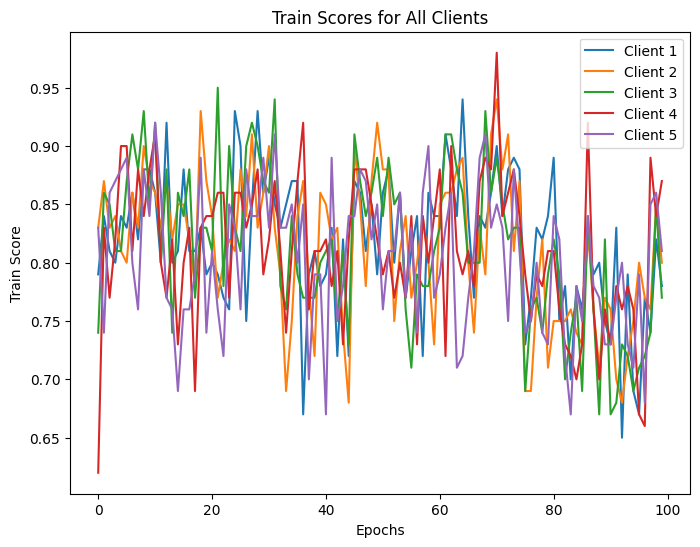

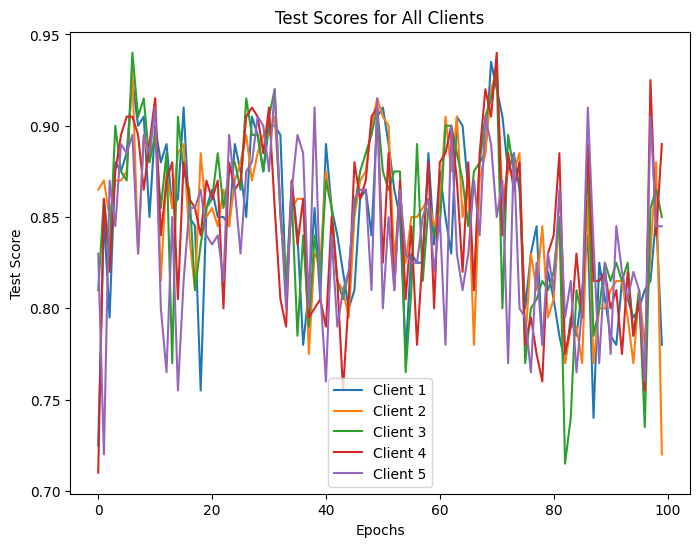

In [93]:
import matplotlib.pyplot as plt

# Create two figures, one for train scores and one for test scores
plt.figure(figsize=(8, 6))

# Plot train scores for all clients
for client in clients:
    plt.plot(client.train_scores, label=f'Client {clients.index(client) + 1}')

plt.xlabel('Epochs')
plt.ylabel('Train Score')
plt.title('Train Scores for All Clients')
plt.legend()

# Show the train scores plot
plt.show()

# Create a new figure for test scores
plt.figure(figsize=(8, 6))

# Plot test scores for all clients
for client in clients:
    plt.plot(client.test_scores, label=f'Client {clients.index(client) + 1}')

plt.xlabel('Epochs')
plt.ylabel('Test Score')
plt.title('Test Scores for All Clients')
plt.legend()

# Show the test scores plot
plt.show()


## Visualization of Client Training Scores

In this code, we create visualizations to testing scores of each client and the global model across different epochs.


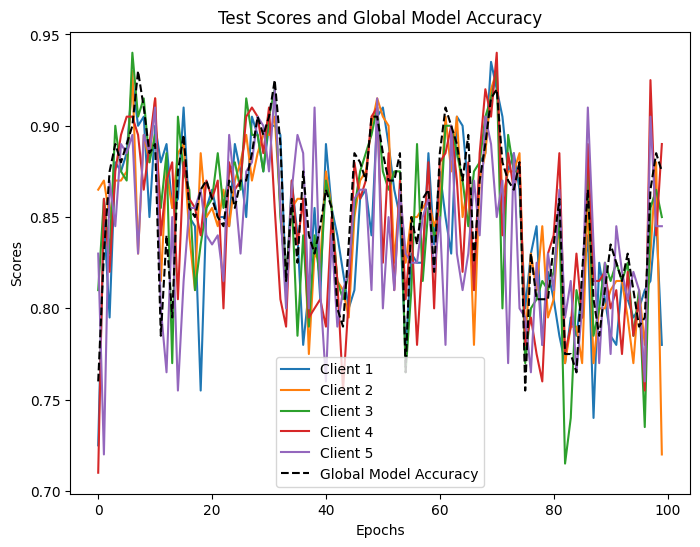

In [94]:
import matplotlib.pyplot as plt

# Create a figure for the test scores
plt.figure(figsize=(8, 6))

# Plot test scores for all clients
for client in clients:
    plt.plot(client.test_scores, label=f'Client {clients.index(client) + 1}')

# Plot global model accuracy
plt.plot(global_model_accuracy, label='Global Model Accuracy', linestyle='--', color='black')

plt.xlabel('Epochs')
plt.ylabel('Scores')
plt.title('Test Scores and Global Model Accuracy')
plt.legend()

# Show the combined graph
plt.show()
